In [1]:
#Metabolic Neural Network in multi-strain systems (4.3.2)
#V2: Metabolic Neural Network based on the structure of GRRANN

In [29]:
import cobra
import numpy as np
import random as rd
import math
from tensorflow.keras.layers import Layer, Lambda, Dense, Multiply, Activation, BatchNormalization, Dropout, Input, concatenate
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import clone_model, load_model
from tensorflow.math import sign as tfsign
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
import keras.backend as K

In [3]:
def prepareNetInput(all_inps):
    inps=[]
    for ind in all_inps:
        inps.append(np.asarray(ind))
    return np.asarray(inps)

def prepareNetOutput(all_outs):
    outs=[[] for i in range(len(all_outs[0]))]
    for ifba in range(len(all_outs)):
        for ilay in range(len(all_outs[ifba])):
            outs[ilay].append(np.array(all_outs[ifba][ilay]))
    for i in range(len(all_outs[0])):
        outs[i]=np.asarray(outs[i])
    return outs

def saveInOut(netInps, netOuts, filebase, append=True):
    '''Save the input and output using pickle
    '''
    infn, outfn = filebase + '_inputs.pickle', filebase + '_outputs.pickle'
    if infn in os.listdir() or outfn in os.listdir():
        if append:
            preinp, preout = loadInOut(filebase)
            netInps = np.append(preinp,netInps,axis=0)
            for i in range(len(preout)):
                netOuts[i] = np.append(preout[i],netOuts[i],axis=0)
    with open(infn, 'wb') as handle:
        pickle.dump(netInps, handle)
    with open(outfn, 'wb') as handle:
        pickle.dump(netOuts, handle)
    return

def loadInOut(filebase):
    '''Load the input and output using pickle
    '''
    infn, outfn = filebase + '_inputs.pickle', filebase + '_outputs.pickle'
    with open(infn,'rb') as finputs:
        netInps = pickle.load(finputs)
    with open(outfn, 'rb') as foutputs:
        netOuts = pickle.load(foutputs)
    return netInps, netOuts

def reitOutputs(netOuts, nreit):
    '''Repeats the first layer of the outputs the number of times that is
    repeated in the model
    '''
    nO=[netOuts[0]]
    for i in range(nreit):
        nO.append(netOuts[0])
    nO.append(netOuts[1])
    return nO

def nonzeroidx_output(output, limit = 0.05):
    '''Find the metabolites that change for all the dataset. A metabolite is considered not to change if its values
    are 0 for more than (1-limit) proportion'''
    nonzero = limit*output.shape[0]
    nonzeros_idx=[]
    for j in range(output.shape[1]):
        cur_nonzeros = len(np.where(abs(output[:,j])>0.001)[0])
        if cur_nonzeros > nonzero and not checkEqual(output[:,j]):
            nonzeros_idx.append(j)
    return nonzeros_idx

#Normalize the outputs
def norm_outputs(outputs, incr=0):
    '''Normalize the outputs as (X-min)/(max-min)
    The range can be increased a % over the maximum and minimum so the predictions can excede the 
    dataset values'''
    mins = np.min(outputs,axis=0) - np.abs(np.min(outputs, axis=0)*incr)
    maxs = np.max(outputs,axis=0) + np.abs(np.max(outputs, axis=0)*incr)
    return (outputs-mins) / (maxs-mins), maxs, mins

#Normalize the outputs
def norm_outputs_withZeros(outputs, incr=0):
    '''Normalize the outputs as (X-min)/(max-min)
    The range can be increased a % over the maximum and minimum so the predictions can excede the 
    dataset values'''
    mins = np.min(outputs,axis=0) - np.abs(np.min(outputs, axis=0)*incr)
    maxs = np.max(outputs,axis=0) + np.abs(np.max(outputs, axis=0)*incr)
    nouts = outputs.copy()
    for j in range(outputs.shape[1]):
        if maxs[j] != mins[j]:
            nouts[:,j] = (outputs[:,j]-mins[j]) / (maxs[j]-mins[j])
    return nouts, maxs, mins

def normTanhOutputs(outputs):
    '''Normalize the outputs as 2((X-min)/(max-min))-1
    In the range [-1, 1]'''
    mins = np.min(outputs,axis=0)
    maxs = np.max(outputs,axis=0)
    zero2one = (outputs-mins) / (maxs-mins)
    return 2 * zero2one - 1, maxs, mins

def norm2real(predictions,maxs,mins):
    '''Return the denormalized values of the output'''
    return predictions * (maxs-mins) + mins

def checkEqual(iterator):
    '''Check if all values in a vector are equal'''
    return len(set(iterator)) <= 1

In [4]:
def random_medium(model, mini=0.0, maxi=1000):
    '''Return a dictionary with random values for the metabolites ina  medium
    '''
    medium={}
    inputIds = get_influxesIds(model)
    for metab in inputIds:
        medium[metab] = rd.uniform(mini, maxi)
    return medium

def batch_of_FBAs_MNN(model, layers, num=100):
    '''Returns two lists with the dictionaries of mediums and fluxes
    '''
    all_mediums = []
    all_outs, all_inps = [], []
    i=0
    while i<num:
        all_mediums.append(random_medium(model))
        cur_fluxes = FBA_output_fluxes_MNN(model, all_mediums[-1], layers)
        if cur_fluxes != None:
            if i%(num/10)==0:
                print('Created {}/{}'.format(i,num))
            all_inps.append(list(all_mediums[-1].values()))
            all_outs.append(cur_fluxes)
            i+=1
    print('Created {}/{}'.format(num,num))
    return prepareNetInput(all_inps), prepareNetOutput(all_outs)

def get_fluxes(m):
    '''Return the metabolites that are exchanged in and out of the cell
    '''
    fluxes = {}
    for exch in m.exchanges:
        fluxes[exch.id] = exch.flux
    return fluxes

def FBA_output_fluxes_MNN(model, medium, layers):
    '''Returns the exchanged fluxes and the biomass with FBA
    '''
    with model:
        model.medium = medium
        biomass=model.slim_optimize()
        if math.isnan(biomass):
            return None
        
        fluxes = []
        for lay in layers:
            fluxes.append([])
            for r in lay:
                fluxes[-1].append(r.flux)
    return fluxes

def get_influxesIds(m):
    '''Returns a list with the metabolites that can be taken by the cell
    '''
    influxes = []
    for exch in m.exchanges:
        if exch.reaction.split()[-1] == '<=>':
            influxes.append(exch.id)
    if 'EX_h2o_e' in influxes:
        influxes.remove('EX_h2o_e')
    return influxes

def get_fluxesIds(m):
    '''Return the metabolites that are exchanged in and out of the cell
    '''
    fluxes = []
    for exch in m.exchanges:
        fluxes.append(exch.id)
    return fluxes

def dic2array(dic):
    '''Return an array that is complementary to the dictionary and the keys of the dictionary'''
    data = []
    for metab in dic:
        data.append(np.array(dic[metab]))
    data = np.array(data).T
    return data, list(dic.keys())

def dataset2dic(inputs, netOutputs, FBAmodel, numberFBAs=-1):
    '''Returns the input, output as dictionaries with the ids of the metabolites as keys'''
    inps, reacts, outs = {}, {}, {}
    reactions, outputs = netOutputs
    
    medium_metabs = get_influxesIds(FBAmodel)
    glayers, glayersIds = grrann_layers(FBAmodel, outputs)
        
    if numberFBAs == -1:
        numberFBAs = inputs.shape[0]
        
    for i in range(len(medium_metabs)):
        inps[medium_metabs[i]] = list(inputs[:numberFBAs,i])
        
    for i in range(len(glayersIds[0])):
        reacts[glayersIds[0][i]] = list(reactions[:numberFBAs,i])
    
    for i in range(len(glayersIds[-1])):
        outs[glayersIds[-1][i]] = list(outputs[:numberFBAs,i])
     
    return inps, reacts, outs

def addDicIndivs(cur_dic, total_dic, addNew=True):
    '''Add the data in the cur_dic into the total_dic
    Metabs in the toal_dic that are not found in cur_dic are filled with 0s for this cur_dic individuals
    Metabs in the cur_dic that are not found in the total_dic are added filling with 0s for the previous individuals (addMetab2dic)'''
    ninds = len(cur_dic[list(cur_dic.keys())[0]])
    if total_dic == {}:
        prev_ninds = 0
    else:
        prev_ninds = len(total_dic[list(total_dic.keys())[0]])
    for metab in total_dic:
        if metab in cur_dic:
            total_dic[metab] += cur_dic[metab]
        else:
            total_dic[metab] += [0]*ninds
    if addNew:
        for metab in cur_dic:
            if not metab in total_dic:
                total_dic = addMetab2dic(metab,total_dic, prev_ninds)
                total_dic[metab] += cur_dic[metab]            
    return total_dic

def addMetab2dic(metab, dic, ninds):
    '''Add a metabolite to the dic that was not present before, filling with zeros that metabolite in the previous indivs'''
    dic[metab] = [0] * ninds
    return dic

def get_inputReactions(m):
    '''Returns a list with the reactions of the metabs that can be taken by the cell
    '''
    influxes = []
    for exch in m.exchanges:
        if exch.reaction.split()[-1] == '<=>':
            if exch.id != 'EX_h2o_e':
                influxes.append(exch)
    return influxes

def get_outputReactions(m):
    '''Return the list with the reactions that are exchanged in and out of the cell
    '''
    fluxes = []
    for exch in m.exchanges:
        if exch.id != 'EX_h2o_e':
            fluxes.append(exch)
    return fluxes

def get_inputMetabs(m):
    '''Returns a list with the metabs that can be taken by the cell
    '''
    reactions = get_inputReactions(m)
    metabs=[]
    for r in reactions:
        if not 'h_e' in r.reactants[0].id:
            metabs.append(r.reactants[0])
    return metabs

def get_outputMetabs(m):
    '''Return the list with the metabs that are exchanged in and out of the cell
    '''
    reactions = get_outputReactions(m)
    metabs = []
    for r in reactions:
        metabs.append(r.reactants[0])
    return metabs

def deleteMetabolites(vector, metabs):
    '''Remove metabolites objects which ids are in the list metabs from the list vector
    '''
    for m in vector:
        if m.id in metabs:
            vector.remove(m)
    return vector

def getReactantsProducts(reaction):
    '''Return the reactants and the products of a reaction. Takes in account if the reaction
    is reversible
    '''
    notInclude = ['h_c','h_e', 'h2o_e', 'h2o_c']
    r_raw, p_raw = reaction.reactants, reaction.products
    r, p = deleteMetabolites(r_raw, notInclude), deleteMetabolites(p_raw, notInclude)
    if not '<' in reaction.reaction:
        return r, p
    else:
        return r+p, r+p

def metabolitesGraph(m):
    '''Create a graph where the nodes are the reactions.
    Graph: {metabSource:[metabsTarget]}
    '''
    graph = {}
    for reaction in m.reactions:
        reactants, products = getReactantsProducts(reaction)
        for r in reactants:
            if not r in graph:
                graph[r] = []
            for p in products:
                graph[r].append(p)

    #Adding final metabolites with no further reactions
    for met in m.metabolites:
        if met not in graph:
            graph[met]=[]
    return graph

def get_inicialReacts(m):
    '''Returns the initial reactions (the ones where the external input metabolites are included
    '''
    iReacts = []
    sourcesMetabs = get_inputMetabs(m)
    for r in m.reactions:
        if not 'EX_' in r.id:
            for met in r.reactants:
                if met in sourcesMetabs:
                    iReacts.append(r)
    return iReacts

def reactionsGraph(m):
    '''Create a graph where the nodes are the reactions.
    Graph: {reactionSource:[reactionsTarget]}
    '''
    graph = {}
    for metab in m.metabolites:
        users, producers = [], []
        for r in metab.reactions:
            reactants, products = getReactantsProducts(r)
            if metab in reactants:
                users.append(r)
            if metab in products:
                producers.append(r)
            
        for p in producers:
            if not p in graph:
                graph[p]=[]
            for u in users:
                if u!=p:
                    graph[p].append(u)
    #Adding final reactions with no further reactions
    for r in m.reactions:
        if r not in graph:
            graph[r]=[]
    return graph


In [5]:
def bfs_layers(graph, sources):
    '''Return the layers corresponding to the distance to the sources in a directed graph
    using breadth first search. #Biomass added after bigger layer.
    '''
    layers, vis = [sources],[*sources]
    layersIds=[[]]
    for s in vis:
        layersIds[0].append(s.id)

    il=0
    while len(layers[il]) > 0:
        layers.append([])
        layersIds.append([])
        for s in layers[il]:
            for t in graph[s]:
                if not t in vis:
                    vis.append(t)
                    layers[-1].append(t)
                    layersIds[-1].append(t.id)
        il+=1
    layers.pop()
    layersIds.pop()
##    longerLayer = layers.index(max(layers,key=len))
##    layers[longerLayer+1].append('Biomass')
##    layersIds[longerLayer+1].append('Biomass')
    return layers, layersIds

def findRealBiomass(exIds, outputs):
    '''Find the real biomass index'''
    maxidx, maxis = [], []
    for i in range(len(exIds)):
        exId = exIds[i]
        if 'biomass' in exId.lower():
            maxis.append(np.mean(outputs[:,i]))
            maxidx.append(i)
    preIdx = maxis.index(max(maxis))
    bioIdx = maxidx[preIdx]
    return bioIdx

def grrann_layers(m, outputs = 2):
    '''Given a cobra model, returns a list with the reactions of the model and another list
    with its exchanges and the BIOMASS reactions 
    Sometimes, there appear several biomass reactions, most of them null. To recognise the real biomass reaction
    we need data (outputs) and check which has the maximum values
    '''
    reactions, exchanges = [], []
    reIds, exIds = [], []
    for reaction in m.reactions:
        if 'EX_' in reaction.id or 'BIOMASS' in reaction.id:
            exchanges.append(reaction)
            exIds.append(reaction.id)
        else:
            reactions.append(reaction)
            reIds.append(reaction.id)
            
    if type(outputs) == type(np.array([])):
        bioIdx = findRealBiomass(exIds, outputs)
        exIds[bioIdx] = 'Biomass'
    
    return [reactions, exchanges], [reIds, exIds]

In [6]:
def build_MNNv1_0(inp_medium, layers):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)
    inputLayer = Input(shape=(ninp,))
    x=Dense(ninp*3, activation='relu', name='inputLayer0')(inputLayer)
    x=Dense(ninp*3, activation='relu', name='inputLayer1')(x)
    
    mLayer0=Dense(len(layers[0])+10, activation='relu', name='mLayer0')(x)
    out0 = Lambda(lambda x: x[:,:len(layers[0])])(mLayer0)
    
    mLayer1=Dense(len(layers[1])+10, activation='relu', name='mLayer1')(mLayer0)
    mLayer2=Dense(len(layers[2])+10, activation='relu', name='mLayer2')(mLayer1)
    mLayer3=Dense(len(layers[3])+10, activation='relu', name='mLayer3')(mLayer2)
    mLayer4=Dense(len(layers[4])+10, activation='relu', name='mLayer4')(mLayer3)

    model = Model(inputs=inputLayer,
                  outputs=[out0, mLayer1, mLayer2, mLayer3, mLayer4],
                  name="metabolicnnet")
    return model

def build_MNNv1_1(inp_medium, layers):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)
    extraNeurons = 40
    
    inputLayer = Input(shape=(ninp,), name='Input_medium')
    x=Dense(ninp*4, activation='relu', name='Extra_layer1')(inputLayer)

    mnLayers=[Dense(ninp*3, activation='relu', name='Extra_layer2')(x)]
    outs, losses, wlosses = [], {}, {}
    for i in range(len(layers)):
        mnLayers.append(Dense(len(layers[i])+extraNeurons, activation='linear',
                              name='mLayer'+str(i))(mnLayers[-1]))
        losses['Output'+str(i)]='mean_squared_error'
        wlosses['Output'+str(i)]=len(layers[i])
        outs.append(Lambda(lambda x: x[:,:len(layers[i])],
                           name='Output'+str(i))(mnLayers[-1]))

    model = Model(inputs=inputLayer,
                  outputs=outs,
                  name="metabolicnnet")
    model.compile(optimizer='Adam', metrics=['mae'],
                  loss=losses, loss_weights = wlosses)
    return model

def build_MNNv2_0(inp_medium, layers, nreit, reactLossW = 0.5):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)

    #Input layer with the medium concentrations
    inputLayer = Input(shape=(ninp,), name='Input_medium')

    #Reactions layers repeated nreit times as dense layers
    outs, losses, wlosses = [], {}, {}
    mnnLayers=[Dense(len(layers[0]), activation='linear',
                     name='ReactLayer0')(inputLayer)]
    losses['ReactLayer0'] = 'mean_squared_error'
    wlosses['ReactLayer0'] = reactLossW/(nreit+1)
    outs.append(mnnLayers[-1])
    for i in range(1,nreit+1):
        mnnLayers.append(Dense(len(layers[0]), activation='tanh',
                              name='ReactLayer'+str(i))(mnnLayers[-1]))
        losses['ReactLayer'+str(i)] = 'mean_squared_error'
        wlosses['ReactLayer'+str(i)] = reactLossW/(nreit+1)
        outs.append(mnnLayers[-1])

    #Output layer with the fluxes exchanges
    outputLayer = Dense(len(layers[1]), activation='tanh',name='OutputLayer')(mnnLayers[-1])
    losses['OutputLayer'] = 'mean_squared_error'
    wlosses['OutputLayer'] = 1-reactLossW
    outs.append(outputLayer)

    model = Model(inputs=inputLayer,
                  outputs=outs,
                  name="MetabolicNeuralNetv2.0")
    model.compile(optimizer='Adam', metrics=['mae'],
                  loss=losses, loss_weights = wlosses)
    return model

In [7]:
class CustomConnected(Dense):
    '''Derivation of a Dense layer where the conexions can be specified'''
    def __init__(self,units,connections,**kwargs):
        #this is matrix A
        self.connections = connections  
        self.unit = units
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self, inputs):
        output = K.dot(inputs, self.kernel * self.connections)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def get_config(self):
        config = {'connections': self.connections,
                  'units': self.units}
        base_config = super(CustomConnected, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def metabsNoCompartment(metabs):
    '''Return a list with the metabolites in metabs removing the compartment (metab_comp)
    '''
    ms=[]
    for m in metabs:
        ms.append('_'.join(m.id.split('_')[:-1]))
    return ms
    
def getConnectionsMatrix(glayers):
    '''Build the sparse connections matrix for the last layer of the MNNv2
    Reactions in previous layer which use or produce the metabolite exchanged in the neuron
    of the output layer are set to 1.
    '''
    mat = np.zeros((len(glayers[0]), len(glayers[1])))
    for i in range(len(glayers[0])):
        metabs = list(glayers[0][i].metabolites.keys())
        metabs = metabsNoCompartment(metabs)
        for j in range(len(glayers[1])):
            exchangeMetabs = list(glayers[1][j].metabolites.keys())
            exchangeMetabs = metabsNoCompartment(exchangeMetabs)
            common = set(metabs).intersection(set(exchangeMetabs))
            if len(common)>0:
                mat[i,j]=1
    return mat

def conventionalNN(x_train, y_train, act='relu'):
    '''Returns a model with a conventional fully connected neural network'''  
    x_train, y_train = np.array(x_train), np.array(y_train)
    ninp, nout = x_train[0].shape[1], y_train.shape[1]
    model = Sequential()
    model.add(Dense(512, input_shape=(ninp,), activation=act))
    model.add(Dense(nout))
    
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=["accuracy",'mae'])
    return model

def build_MNNv2_1(inp_medium, layers, nreit, activs = ['relu', ''], matConnections=[], reactLossW = 0.5):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)
    if matConnections == []:
        matConnections = np.ones((len(layers[0]), len(layers[1])))

    #Input layer with the medium concentrations
    inputLayer = Input(shape=(ninp,), name='Input_medium')

    #Reactions layers repeated nreit times as dense layers
    outs, losses, wlosses = [], {}, {}
    mnnLayers=[Dense(len(layers[0]), activation = activs[0],
                     name='ReactLayer0')(inputLayer)]
    losses['ReactLayer0'] = 'mean_squared_error'
    wlosses['ReactLayer0'] = reactLossW/(nreit+1)
    outs.append(mnnLayers[-1])
    for i in range(1,nreit+1):
        mnnLayers.append(Dense(len(layers[0]), activation = activs[0],
                              name='ReactLayer'+str(i))(mnnLayers[-1]))
        losses['ReactLayer'+str(i)] = 'mean_squared_error'
        wlosses['ReactLayer'+str(i)] = reactLossW/(nreit+1)
        outs.append(mnnLayers[-1])

    #Output layer with the fluxes exchanges
    if activs[1] != '':
        outputLayer = CustomConnected(len(layers[1]), matConnections, activation = activs[1],
                                      name='OutputLayer')(mnnLayers[-1])
    else:
        outputLayer = CustomConnected(len(layers[1]), matConnections,
                                      name='OutputLayer')(mnnLayers[-1])
    losses['OutputLayer'] = 'mean_squared_error'
    wlosses['OutputLayer'] = 1-reactLossW
    outs.append(outputLayer)

    model = Model(inputs=inputLayer,
                  outputs=outs,
                  name="MetabolicNeuralNetv2.0")
    model.compile(optimizer='Adam', metrics=['mae'],
                  loss=losses, loss_weights = wlosses)
    return model

def build_MNNv2_2(inp_medium, layers, nreit, nneurons=128, activ='relu', matConnections=[], reactLossW = 0.5):
    '''Build an Metabolic Neural Network where where each neuron represents a reaction
    There might be extra neurons to cover some dependencies.
    The input layer covers the fluxes in the medium, then 2 extra layers are added, to
    predict the actual flux of this metabolites into the cell, which is the first metabolic layers
    '''
    ninp = len(inp_medium)

    #Input layer with the medium concentrations
    inputLayer = Input(shape=(ninp,), name='Input_medium')

    #Extra Dense layers
    mnnLayers=[Dense(nneurons, activation=activ)(inputLayer)]
    for i in range(1,nreit+1):
        mnnLayers.append(Dense(nneurons, activation=activ)(mnnLayers[-1]))
    
    #Reaction layer 
    outs, losses, wlosses = [], {}, {}
    rLayer=Dense(len(layers[0]), activation='relu', name='ReactLayer')(mnnLayers[-1])
    losses['ReactLayer'] = 'mean_squared_error'
    wlosses['ReactLayer'] = reactLossW
    outs.append(rLayer)

    #Output layer with the fluxes exchanges
    if matConnections == []:
        outputLayer = Dense(len(layers[1]), name='OutputLayer')(rLayer)
    else:
        outputLayer = CustomConnected(len(layers[1]), matConnections,
                                      name='OutputLayer')(rLayer)
    losses['OutputLayer'] = 'mean_squared_error'
    wlosses['OutputLayer'] = 1-reactLossW
    outs.append(outputLayer)

    model = Model(inputs=inputLayer,
                  outputs=outs,
                  name="MetabolicNeuralNetv2.0")
    model.compile(optimizer='Adam', metrics=['mae'],
                  loss=losses, loss_weights = wlosses)
    return model

In [42]:
#Layer that masks the selected neurons so their outputs become 0
class maskedActivation0(Layer):
    '''Derivation of a Dense layer where the conexions can be specified'''
    def __init__(self,mask,**kwargs):
        #this is matrix A
        self.mask = mask                        
        #initalize the original Dense with all the usual arguments   
        super(maskedActivation0,self).__init__(**kwargs)  

    def call(self, inputs):
        output = inputs * self.mask
        return output
    
class maskedActivation(Layer):
    '''Derivation of a Dense layer where the conexions can be specified'''
    def __init__(self,mask,**kwargs):
        #this is matrix A
        self.mask = mask                        
        #initalize the original Dense with all the usual arguments   
        super(maskedActivation,self).__init__(**kwargs)  

    def call(self, inputs):
        signs = tfsign(inputs)
        output = Multiply()([K.minimum(K.abs(inputs), self.mask), signs])
        return output

def tryNet(nneu):
    inputLayer = Input(shape=(nneu,), name='Input_medium')
    inputReact = Input(shape=(nneu,))
    #x=Dense(4, activation ='relu')(inputLayer)
    x=maskedActivation(inputReact, name='maskedFluxes')(inputLayer)
    model = Model(inputs=[inputLayer, inputReact],
                  outputs=x,
                  name="trial")
    return model

do=False
if do:
    #xMed = [[-1,1,1,1], [2,2,-2,2], [3,3,-3,3], [4,-4,4,-4], [5,5,5,5]]
    #xMask = [[0.5,0,1,0], [0,0,0.5,0], [1,0.5,1,0], [1,4,1,3], [0,0,0,0]]
    #outs = [[-0.5,0,1,0],[0,0,-0.5,0], [3,3,-1,0], [4,-4,4,-4], [0,0,0,0]]
    
    xMed = np.random.randint(-5,5, size=(10000,20))
    xMask = np.random.randint(-5,5, size=(10000,20))
    outs = np.random.randint(-5,5, size=(10000,20))
    
    n=tryNet(xMed.shape[1])
    n.summary()

    n.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    n.fit([xMed, xMask], [outs])

    print(n.predict([xMed, xMask]))

In [9]:
def crossvalidationSets(inputs, ncv, j):
    '''Retuns the training and testing subset of the set (inputs) for the ncv-folds crossvalidation
    in the iteration j'''
    n=inputs[0].shape[0]
    x_train, x_test = [], []
    for i in range(len(inputs)):
        xtrain1 = inputs[i][:int(n/ncv*j),:]
        xtrain2 = inputs[i][int(n/ncv*j+n/ncv):,:]
        xtrain12 = np.vstack([xtrain1,xtrain2])
        x_train.append(xtrain12)
        x_test.append(inputs[i][int(n/ncv*j):int(n/ncv*j+n/ncv),:])
    return x_train, x_test

def biomassIndex(glayersIds):
    '''Returns the biomass index'''
    for i in range(len(glayersIds)):
        if 'Biomass'  == glayersIds[i]:
            return i
    
def plotRealsPreds(reals, preds):
    bins = list(range(len(reals)))
    plt.plot(bins, reals, label='Reals')
    plt.plot(bins, preds, label='Preds')
    plt.legend(loc='upper right')
    plt.show()

def divide_set(s, train_prop, val_prop):
    '''Return the set divided in training, validationa and test sets'''
    val_prop = train_prop + val_prop
    x_train, x_val, x_test = [], [], []
    for i in range(len(s)):
        x_train.append(s[i][:int(train_prop*s[i].shape[0])])
        x_val.append(s[i][int(train_prop*s[i].shape[0]):int(val_prop*s[i].shape[0])])
        x_test.append(s[i][int(val_prop*s[i].shape[0]):])
    return x_train, x_val, x_test

def shuffle_dataset(datas):
    '''Randomly shuffles the databaset inputs and outputs with the same order (their rows are shuffled)'''
    s = np.arange(datas[0].shape[0])
    np.random.shuffle(s)
    for i in range(len(datas)):
        datas[i] = datas[i][s,:]
    return datas

def mean_square_error(a,b):
    '''Mean square error between two list numpy arrays'''
    return np.square(a-b).mean()

def mean_absolute_error(a,b):
    '''Mean absolute error between two list numpy arrays'''
    return np.abs(a-b).mean()

def plot_prediction_comparison(predictions, real, metab):
    '''Plot an histogram with the real and several predicted values overlapped'''
    maxi=100
    if len(real) > maxi:
        for i in range(len(predictions)):                       
            predictions[i]=predictions[i][:maxi]
        real=real[:maxi]
    
    bins = list(range(len(real)))
    if len(predictions) == 1:                           
        x, y = zip(*sorted(zip(real, predictions[0])))
    else:
        x, y, z = zip(*sorted(zip(real, predictions[0], predictions[1])))
        plt.scatter(bins, z, alpha=0.5, label='Prediction 2')

    plt.scatter(bins, x, alpha=0.5, label='Real')
    plt.scatter(bins, y, alpha=0.5, label='Prediction 1')
    plt.legend(loc='upper left')
    plt.title('Metabolite: {}'.format(metab))
    plt.show()
    
def plot_outputMNNv1(history):
    # PLOT LOSS AND ACCURACY
    %matplotlib inline
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data sets for each training epoch
    #-----------------------------------------------------------
    loss=history.history['loss']
    epochs=range(len(loss)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation MAE per epoch
    #------------------------------------------------
    for i in history.history:
        if not 'loss' in i:
            plt.plot(epochs, history.history[i], label=i)
    
    #plt.legend(loc='upper right')
    plt.title('Losses and MAEs')
    plt.show()
    
def plot_output(history, nreit):
    # PLOT LOSS AND ACCURACY
    %matplotlib inline
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data sets for each training epoch
    #-----------------------------------------------------------
    react_mae=history.history['ReactLayer{}_mean_absolute_error'.format(nreit)]
    val_react_mae=history.history['val_ReactLayer{}_mean_absolute_error'.format(nreit)]
    out_mae=history.history['OutputLayer_mean_absolute_error']
    val_out_mae=history.history['val_OutputLayer_mean_absolute_error']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(1,len(loss)+1) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation MAE per epoch
    #------------------------------------------------
    plt.plot(epochs, react_mae, 'pink', label="Reactions Training MAE")
    plt.plot(epochs, out_mae, 'c', label="Output Training MAE")
    plt.plot(epochs, val_react_mae, 'r', label="Reactions Validation MAE")
    plt.plot(epochs, val_out_mae, 'b', label="Output Validation MAE")
    plt.legend(loc='upper right')

    plt.title('Validation MAE')
    plt.grid(linestyle='dotted')
    plt.xlabel('Number of epochs')
    plt.ylabel('MAE')
    plt.show()
    
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs[1:], loss[1:], 'r', label="Loss")
    plt.plot(epochs[1:], val_loss[1:], 'b', label="Validation loss")
    plt.legend(loc='upper right')

    plt.title('Training and validation loss')
    plt.grid(linestyle='dotted')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.show()
    
def squareShape(n):
    '''Return the 2D shapes of a line vector, making it square'''
    sq = math.sqrt(n)
    if sq == int(sq):
        return (int(sq), int(sq))
    else:
        sq = int(sq)
        if sq*(sq+1) >= n:
            return (sq+1, sq)
        else:
            return (sq+1, sq+1)

def nonExactReshape(ar, nShape, fillValue=0):
    '''Reshape a vector array into a 2D array with shape nShape, filling values with 0.
    The values are filled by rows'''
    nar = np.zeros(nShape)
    nar.fill(fillValue)
    ii=0
    for i in range(nShape[0]):
        for j in range(nShape[1]):
            nar[i,j] = ar[ii]
            ii+=1
            if ii>=len(ar):
                return nar
    
def plotHeatmap(normOutPreds, yTest, heatIdx, fillValue=0, save = None):
    '''Plot the heatmap of the real and the prediction values
    normOutPreds: array with normalized predictions
    yTest: array with normalized real values'''
    valsPred, valsReal = normOutPreds[heatIdx,:], yTest[heatIdx]
    nShape = squareShape(len(normOutPreds[heatIdx,:]))
    valsPred = nonExactReshape(valsPred, nShape, fillValue = fillValue) 
    valsReal = nonExactReshape(valsReal, nShape, fillValue = fillValue)

    fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[7,7,0.5]))
    sns.heatmap(valsPred, annot=False, linewidths=.1, cmap='seismic', cbar=False, ax=axs[0])
    sns.heatmap(valsReal, annot=False,  linewidths=.1, cmap='seismic', yticklabels=False, 
                cbar=False, ax=axs[1])
    fig.colorbar(axs[1].collections[0], cax=axs[2])
    axs[0].title.set_text('Prediction outputs')
    axs[1].title.set_text('Real outputs')
    plt.tight_layout()
    if save != None:
        plt.savefig('images/{}.png'.format(save))
    plt.show()

In [10]:
def updateDic(dic, keys, values):
    '''Updates a dictionary with new keys:values'''
    for i in range(len(keys)):
        dic[keys[i]] = values[i]
    return dic

def emptyDic(dic):
    '''Return an empty dic maintaining the keys'''
    ndic={}
    for k in dic:
        ndic[k]=[]
    return ndic

def real2norm(predictions, maxs, mins):
    '''Return the normalized values of the output (with predefined maxs and mins)'''
    return (predictions-mins) / (maxs-mins)

def adaptInputOutputMultiStrain(netInps, netOuts, FBAmodel, net_inputs_dic, net_reactions_dic, net_outputs_dic):
    '''Adapts a FBAmodel dataset to have the same inputs and outpus of the neural network trained model
    Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
    Returns: Inputs dictionary, outputs dictionary'''
    #Remove mold individuals from the dataset, adapting the dataset to the model inputs, outputs
    inputs_dic = emptyDic(net_inputs_dic)
    reactions_dic = emptyDic(net_reactions_dic)
    outputs_dic = emptyDic(net_outputs_dic)
    
    cur_inp_dic, cur_react_dic, cur_out_dic = dataset2dic(netInps, netOuts, FBAmodel)
    
    net_inputs_dic = addDicIndivs(cur_inp_dic, inputs_dic, False)
    net_reactions_dic = addDicIndivs(cur_react_dic, reactions_dic, False)
    net_outputs_dic = addDicIndivs(cur_out_dic, outputs_dic, False)

    return net_inputs_dic, net_reactions_dic, net_outputs_dic

def copyKerasModel(model):
    '''Return a deep copy of a keras model'''
    model_copy = clone_model(model)
    model_copy.compile(optimizer='Adam', loss='mean_squared_error', metrics = ['mae'])
    model_copy.set_weights(model.get_weights())
    return model_copy

In [11]:
#Loading the cobra models and chosing the neural network system
dataFolder = 'C:/Users/danie/Desktop/ia/tfm/red_FBA/'
dataf = 'modelsMixed/'

#Chosing the Ecoli or Complete database
modelBases = ['iEC042', 'iAPECO1', 'iJO1366', 'iWFL', 'iYS1720']
if len(modelBases) == 5:
    multiStrainVersion = 'Complete'
    nFBAs = 2000
elif len(modelBases) == 4:
    multiStrainVersion = 'Ecoli'
    nFBAs = 2500
else:
    multiStrainVersion = 'other'

#Architecture version and number of extra layers
nreit=0
v=21    

#Use of the Full or Sparse version
spar=True
if spar and v==22:
    sparsed='Sparsed'
else:
    sparsed=''

#Load the cobra models
models = []
for i in range(len(modelBases)):
    print('Loading: ', modelBases[i])
    models.append(cobra.io.load_json_model(dataFolder + dataf + modelBases[i] + '.json'))


Loading:  iEC042
Loading:  iAPECO1
Loading:  iJO1366
Loading:  iWFL
Loading:  iYS1720


In [26]:
#Load the dataset
#mCore, mEC042, mWFL = models
mIdx = 4

create = False
allModels = True

if not allModels:
    mCobra = models[mIdx]
    medium_metabs = get_influxesIds(mCobra)
    filebase = '{}_MNNv2_test'.format(modelBases[mIdx])
    glayers, glayersIds = grrann_layers(mCobra)
    print('loading: ', filebase)
    if create:
        netInps, netOuts = batch_of_FBAs_MNN(mCobra, glayers, nFBAs)
        saveInOut(netInps, netOuts, filebase, append=True)
    netInps, netOuts = loadInOut(filebase)
    if nFBAs < netInps.shape[0]:
        netInps = netInps[:nFBAs,:]
        netOuts[0] = netOuts[0][:nFBAs,:]
        netOuts[1] = netOuts[1][:nFBAs,:]
else:
    net_inputs_dic, net_reactions_dic, net_outputs_dic = {}, {}, {}
    reactionsIds, outputsIds = {}, {}
    for i in range(len(models)):
        mCobra = models[i]
        filebase = '{}_MNNv2'.format(modelBases[i])
        print('Loading: ', filebase)
        glayers, glayersIds = grrann_layers(mCobra)
        
        if create:
            netInps, netOuts = batch_of_FBAs_MNN(mCobra, glayers, nFBAs)
            saveInOut(netInps, netOuts, filebase, append=True)
        netInps, netOuts = loadInOut(filebase)
        
        #Ids of the reactions, caring that the biomass is the real
        glayers, glayersIds = grrann_layers(mCobra, netOuts[1])
        reactionsIds = updateDic(reactionsIds, glayersIds[0], glayers[0])
        outputsIds = updateDic(outputsIds, glayersIds[1], glayers[1])
     
        cur_inp_dic, cur_react_dic, cur_out_dic = dataset2dic(netInps, netOuts, mCobra, nFBAs)
        net_inputs_dic = addDicIndivs(cur_inp_dic, net_inputs_dic)
        net_reactions_dic = addDicIndivs(cur_react_dic, net_reactions_dic)
        net_outputs_dic = addDicIndivs(cur_out_dic, net_outputs_dic)

    netOuts=[[],[]]
    netInps, medium_metabs = dic2array(net_inputs_dic)
    netOuts[0], reaction_metabs = dic2array(net_reactions_dic)
    netOuts[1], fluxes_metabs_raw = dic2array(net_outputs_dic)
    
    glayersIds, glayers = [[],[]], [[],[]]
    glayersIds[0], glayers[0] = list(reactionsIds.keys()), list(reactionsIds.values())
    glayersIds[1], glayers[1] = list(outputsIds.keys()), list(outputsIds.values())
        
print('\nInput shape: ',netInps.shape)
print('Reactions shape: ',netOuts[0].shape)
print('Exchanges shape: ',netOuts[-1].shape)

Loading:  iEC042_MNNv2
Loading:  iAPECO1_MNNv2
Loading:  iJO1366_MNNv2
Loading:  iWFL_MNNv2

Input shape:  (10000, 24)
Reactions shape:  (10000, 2471)
Exchanges shape:  (10000, 386)


In [27]:
#Preprocess the output
#Filter the output metabolites, only predicted those with considerable change
nonzerosIdx=[[],[]]
nonzerosIdx[0] = nonzeroidx_output(netOuts[0], limit = 0.05)
nonzerosIdx[1] = nonzeroidx_output(netOuts[-1], limit = 0.05)

for i in range(2):
    netOuts[i] = netOuts[i][:,nonzerosIdx[i]]
    glayersIds[i] = np.array(glayersIds[i])[nonzerosIdx[i]]
    glayers[i] = np.array(glayers[i])[nonzerosIdx[i]]
    
inout = shuffle_dataset([netInps, *netOuts])
netInps, netOuts = inout[0], inout[1:]

#Backup of input, outputs
oriNetInps = netInps.copy()
oriNetOuts = [netOuts[0].copy(), netOuts[1].copy()]

print('Input shape: ',netInps.shape)
print('Reactions shape: ',netOuts[0].shape)
print('Exchanges shape: ',netOuts[-1].shape)

Input shape:  (10000, 24)
Reactions shape:  (10000, 492)
Exchanges shape:  (10000, 25)


In [14]:
netInps = oriNetInps.copy()
netOuts = [oriNetOuts[0].copy(), oriNetOuts[1].copy()]

In [15]:
#Normalizing inputs and outputs
netInps /= 1000
outMaxs, outMins = [[],[]], [[],[]]
for i in range(2):
    netOuts[i], outMaxs[i], outMins[i] = norm_outputs(netOuts[i])

In [16]:
#Adapt the outputs to the system version
#MNN version: 21=GRRANN, 22=HBB
if v==21:
    netOuts = reitOutputs(netOuts, nreit)
matCon = getConnectionsMatrix(glayers)

In [35]:
#Muilding the MNN system
if v==21:
    modelMNN = build_MNNv2_1(medium_metabs, glayersIds, nreit)#, matConnections=matCon)
elif v==22:
    modelMNN = build_MNNv2_2(medium_metabs, glayersIds, nreit, nneurons=128)#, matConnections=matCon)
modelMNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_medium (InputLayer)    (None, 25)                0         
_________________________________________________________________
ReactLayer0 (Dense)          (None, 610)               15860     
_________________________________________________________________
OutputLayer (CustomConnected (None, 27)                16497     
Total params: 32,357
Trainable params: 32,357
Non-trainable params: 0
_________________________________________________________________


In [28]:
#Prepare the dataset
trainProp, valProp = 0.9, 0.1
realReacts, realOuts = norm2real(netOuts[-2], outMaxs[0], outMins[0]), norm2real(netOuts[-1], outMaxs[1], outMins[1])

xTrain, xVal, xTest = divide_set([netInps], trainProp, valProp)
yTrain, yVal, yTest = divide_set(netOuts, trainProp, valProp)
ryTrain, ryVal, ryTest = divide_set([realReacts, realOuts], trainProp, valProp)

In [37]:
#Train the neural network
h = modelMNN.fit(xTrain, yTrain, epochs=10, verbose=4,
              validation_data=(xVal, yVal))

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


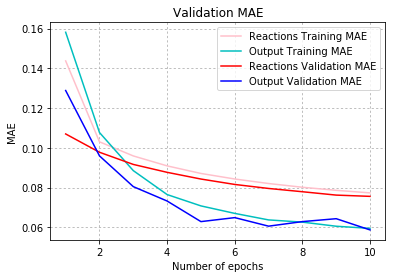

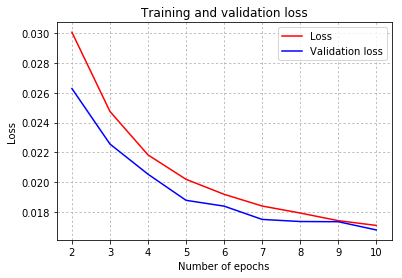

In [38]:
#Plotting the neural network results
if v==21:
    plot_output(h, nreit)
elif v==22:
    plot_output(h, nreit='')

In [30]:
#Predictions with the neural network
results = modelMNN.evaluate(xVal, yVal)
allPreds = modelMNN.predict(xVal)
normReactPreds, normOutPreds = allPreds[-2], allPreds[-1]
reactPreds, outPreds = norm2real(normReactPreds, outMaxs[0], outMins[0]), norm2real(normOutPreds, outMaxs[1], outMins[1])

1000/1000 [==============================] - 0s 285us/sample - loss: 0.0236 - ReactLayer0_loss: 0.0387 - OutputLayer_loss: 0.0087 - ReactLayer0_mean_absolute_error: 0.1050 - OutputLayer_mean_absolute_error: 0.0583


In [17]:
#Checking the errors of the different chosen E.coli and Salmonella strains on the MNN systems
reactionMAEs, outputMAEs = [], []
nij=5
for ij in range(nij):
    print('\nRepetition {} / {}'.format(ij+1, nij))
    #Shuffling rows
    inout = shuffle_dataset([netInps, *netOuts])
    netInps, netOuts = inout[0], inout[1:]

    #Red multi-strain
    net_fn = 'net_MNNv2_multistrain_{}.h5'.format(multiStrainVersion)
    redo = True
    if net_fn in os.listdir() and not redo:
        modelMNN = load_model(net_fn)
    else:
        if v==21:
            modelMNN = build_MNNv2_1(medium_metabs, glayersIds, nreit)#, matConnections=matCon)
        elif v==22:
            modelMNN = build_MNNv2_2(medium_metabs, glayersIds, nreit, nneurons=128, 
                                     matConnections=matCon
                                    )
        #modelMNN.summary()
        historyMNN = modelMNN.fit(netInps, netOuts, epochs=10, verbose=0)
        modelMNN.save(net_fn)

    #Trying the multistrains system in the different strains
    dataFolder2 = 'modelsMixed/'
    modelbases2 = ['iEC042','iAPECO1','iJO1366','iWFL','iYS1720']
    nFBAs2 = 5000

    for i in range(len(modelbases2)):
        modelbase2 = modelbases2[i]
        print('\nResults for :', modelbase2)

        filebase2 = '{}_MNNv2_test'.format(modelbase2)
        FBAmodel2=cobra.io.load_json_model(dataFolder2+modelbase2+'.json')

        netInps2, netOuts2 = loadInOut(filebase2)

        #Take only the desired number of individuals
        if nFBAs2 < netInps2.shape[0]:
            netInps2 = netInps2[:nFBAs2,:]
            netOuts2[0] = netOuts2[0][:nFBAs2,:]
            netOuts2[1] = netOuts2[1][:nFBAs2,:]

        #Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
        inputs_dic2, reactions_dic2, outputs_dic2 = adaptInputOutputMultiStrain(netInps2, netOuts2, FBAmodel2, net_inputs_dic, net_reactions_dic, net_outputs_dic)

        netOuts2 = [[],[]]
        netInps2, medium_metabs2 = dic2array(inputs_dic2)
        netOuts2[0], reaction_metabs2 = dic2array(reactions_dic2)
        netOuts2[1], fluxes_metabs_raw2 = dic2array(outputs_dic2)

        #Shuffling rows
        inout = shuffle_dataset([netInps2, *netOuts2])
        netInps2, netOuts2 = inout[0], inout[1:]

        #Filter the output metabolites, only predicted those with considerable change
        for i in range(2):
            netOuts2[i] = netOuts2[i][:,nonzerosIdx[i]]
        glayersIds2 = glayersIds
        glayers2 = glayers

        #Normalize inputs and outputs
        #Normalizing inputs and outputs
        netInps2 /= 1000
        for i in range(2):
            netOuts2[i] = real2norm(netOuts2[i], outMaxs[i], outMins[i])

        #print('Input shape: ',netInps2.shape)
        #print('Reactions shape: ',netOuts2[0].shape)
        #print('Output shape: ',netOuts2[1].shape)

        print('\n# Evaluate on test data.')
        resultsMNN = modelMNN.evaluate(netInps2, netOuts2)
        reactMAE, outMAE = resultsMNN[-2], resultsMNN[-1]
        
        reactionMAEs.append(reactMAE)
        outputMAEs.append(outMAE)


Repetition 1 / 5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:129 DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Instructions for updating:
Use tf.cast instead.

Results for : iEC042

# Evaluate on test data.
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0356 - ReactLayer_loss: 0.0621 - OutputLayer_loss: 0.0089 - ReactLayer_mean_absolute_error: 0.0581 - OutputLayer_mean_absolute_error: 0.0542

Results for : iAPECO1

# Evaluate on test data.
5000/5000 [==============================] - 0s 46us/sample - loss: 0.0164 - ReactLayer_loss: 0.0239 - OutputLayer_loss: 0.0089 - ReactLayer_mean_absolute_error: 0.0583 - OutputLayer_mean_absolute_error: 0.0544

Results for : iJO1366

# Evaluate on test data.
5000/5000 [==============================] - 0s 44us/sample - loss: 1.7028 - ReactLayer_loss: 3.3802 - OutputLayer_loss: 0.0093 - ReactLayer_mean_absolute_error: 0.0642 - OutputLayer_mean_absolute_error: 0.0549

Results for : iWFL

# Evaluate on test data.
5000/5000 [==============================] - 0s 55us/sample - loss: 0.0157 - ReactLayer_loss: 0.0226 - OutputLayer_loss: 0.008

In [18]:
#Saving the results of the analysis
with open('results/multiStrainAuto{}_v{}{}.csv'.format(multiStrainVersion,v,sparsed),'w') as f:
    f.write('Reations MAEs\n')
    for i in range(nij):
        for j in range(i*nij, (i+1)*nij):
            f.write('{};'.format(reactionMAEs[j]))
        f.write('\n')
    f.write('Outputs MAEs\n')
    for i in range(nij):
        for j in range(i*nij, (i+1)*nij):
            f.write('{};'.format(outputMAEs[j]))
        f.write('\n')

In [17]:
#TRANSFER LEARNING

In [18]:
#Prueba de la red multi-strain Ecoli/complete sobre la cepa de Salmonella
dataFolderS = 'modelsMixed/'
modelbaseS = 'iYS1720'
filebaseS = '{}_MNNv2_test'.format(modelbaseS)
FBAmodelS=cobra.io.load_json_model(dataFolderS+modelbaseS+'.json')
nFBAsS = 10000

netInpsS, netOutsS = loadInOut(filebaseS)

#Take only the desired number of individuals
if nFBAsS < netInpsS.shape[0]:
    netInpsS = netInpsS[:nFBAsS,:]
    netOutsS[0] = netOutsS[0][:nFBAsS,:]
    netOutsS[1] = netOutsS[1][:nFBAsS,:]

#Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
inputs_dicS, reactions_dicS, outputs_dicS = adaptInputOutputMultiStrain(netInpsS, netOutsS, FBAmodelS, net_inputs_dic, net_reactions_dic, net_outputs_dic)


In [19]:
#Dataset to array
netOutsS = [[],[]]
netInpsS, medium_metabsS = dic2array(inputs_dicS)
netOutsS[0], reaction_metabsS = dic2array(reactions_dicS)
netOutsS[1], fluxes_metabs_rawS = dic2array(outputs_dicS)

#Filter the output metabolites, only predicted those with considerable change
for i in range(2):
    netOutsS[i] = netOutsS[i][:,nonzerosIdx[i]]
fluxes_metabs_rawS = np.array(fluxes_metabs_rawS)[nonzerosIdx[1]]
glayersIdsS = glayersIds
glayersS = glayers

#Normalize inputs and outputs
#Normalizing inputs and outputs
netInpsS /= 1000
if multiStrainVersion == 'Complete':
    netOutsS[0] = real2norm(netOutsS[0], outMaxs[0], outMins[0])
else:
    netOutsS[0], reactMaxsS, reactMinsS = norm_outputs_withZeros(netOutsS[0])
netOutsS[1] = real2norm(netOutsS[1], outMaxs[1], outMins[1])

print('Input shape: ',netInpsS.shape)
print('Reactions shape: ',netOutsS[0].shape)
print('Output shape: ',netOutsS[1].shape)

Input shape:  (10000, 25)
Reactions shape:  (10000, 610)
Output shape:  (10000, 26)


In [20]:
#Loading the model
net_fn = 'net_MNNv{}_multistrain_{}{}.h5'.format(v, multiStrainVersion,sparsed)
print('Loading model: ', net_fn)
redo = False
if net_fn in os.listdir() and not redo:
    modelMNN = load_model(net_fn, custom_objects={'CustomConnected': CustomConnected})
else:
    if v==21:
        modelMNN = build_MNNv2_1(medium_metabs, glayersIds, nreit)#, matConnections=matCon)
    elif v==22:
        if sparsed:
            modelMNN = build_MNNv2_2(medium_metabs, glayersIds, nreit, nneurons=128, matConnections=matCon)
        else:
            modelMNN = build_MNNv2_2(medium_metabs, glayersIds, nreit, nneurons=128)#, matConnections=matCon)
    modelMNN.summary()
    historyMNN = modelMNN.fit(netInps, netOuts, epochs=10, verbose=4)
    
    #plot_output(history_met, model_met)
    modelMNN.save(net_fn)

Loading model:  net_MNNv21_multistrain_Complete.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [21]:
#Transfer learning for different number of new retraining isntances
trainProps = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
valProp = 0.1
bioIdx = biomassIndex(glayersIds[-1])

all_oEr, all_rEr = [], []
transf_oMAEs, transf_rMAEs = [], []
for trainProp in trainProps:
    print('\nTraining on {} instances'.format(int(trainProp*netInpsS.shape[0])))
    ncv=4
    oEr, rEr = [], []
    for i in range(ncv):
        #Shuffling rows
        inout = shuffle_dataset([netInpsS, *netOutsS])
        netInpsS, netOutsS = inout[0], inout[1:]
        xTrainS, xValS, xTestS = divide_set([netInpsS], trainProp, valProp)
        yTrainS, yValS, yTestS = divide_set(netOutsS, trainProp, valProp)
    
        model_transferS = load_model(net_fn, custom_objects={'CustomConnected': CustomConnected})
        if trainProp != 0:
            history = model_transferS.fit(xTrainS, yTrainS, epochs=5, verbose=0 , validation_data=(xValS, yValS))
        results = model_transferS.evaluate(xTestS, yTestS, verbose=0)
        
        rEr.append(results[-2])
        oEr.append(results[-1])
    print('Average reactions MAE: ', np.mean(rEr))
    print('Average outputs MAE: ', np.mean(oEr))
    all_oEr.append(oEr)
    all_rEr.append(rEr)
    transf_oMAEs.append(np.mean(oEr))
    transf_rMAEs.append(np.mean(rEr))


Training on 0 instances
Average reactions MAE:  0.079698294
Average outputs MAE:  0.05819149

Training on 100 instances
Average reactions MAE:  0.08500169
Average outputs MAE:  0.09745698

Training on 200 instances
Average reactions MAE:  0.075197496
Average outputs MAE:  0.07868107

Training on 500 instances
Average reactions MAE:  0.065619975
Average outputs MAE:  0.047768302

Training on 1000 instances
Average reactions MAE:  0.06361562
Average outputs MAE:  0.043722622

Training on 2000 instances
Average reactions MAE:  0.061846886
Average outputs MAE:  0.041902855

Training on 5000 instances
Average reactions MAE:  0.05695112
Average outputs MAE:  0.03676098


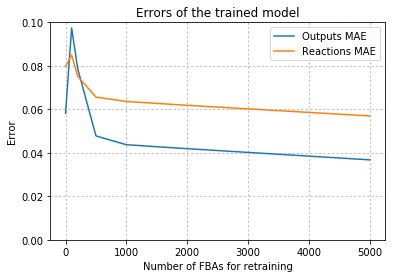

In [23]:
#Plotting the results of the tranfer learning
numInst = np.array(trainProps)* netInpsS.shape[0]
plt.plot(numInst, transf_oMAEs, label='Outputs MAE')
plt.plot(numInst, transf_rMAEs, label='Reactions MAE')

plt.legend(loc='upper right')
plt.xlabel('Number of FBAs for retraining')
plt.ylabel('Error')
plt.ylim(0,0.1)
#plt.axhline(y=0.05, color='r', linestyle='dotted')
plt.title('Errors of the trained model')
plt.grid(linestyle='dotted')
plt.savefig('images/multiTransferSalmonella_{}_{}{}.jpg'.format(multiStrainVersion, v, sparsed))
plt.show()

all_oEr, all_rEr = np.array(all_oEr), np.array(all_rEr)
with open('results/multiTransferSalmonella_{}_{}{}.csv'.format(multiStrainVersion, v, sparsed),'w') as f:
    f.write('Reactions errors\n')
    for j in range(all_rEr.shape[1]):
        for i in range(all_rEr.shape[0]):
            f.write('{};'.format(all_rEr[i,j]))
        f.write('\n')
    
    f.write('Outputs errors\n')
    for j in range(all_oEr.shape[1]):
        for i in range(all_oEr.shape[0]):
            f.write('{};'.format(all_oEr[i,j]))
        f.write('\n')

In [18]:
#Results of the multi-strain systems (Ecoli)
grrannMAEs = [[0.1880062,0.12649872,0.104281023,0.088309953,0.085769819,0.083424641,0.078774322],
              [0.264563099,0.108393375,0.085758636,0.064147708,0.053758752,0.046368218,0.037564239]]

hbbFMAEs = [[0.180128284,0.131305998,0.092580071,0.08034456,0.072830442,0.068482714,0.064397248],
            [0.267660975,0.097570375,0.072516145,0.051745714,0.044486369,0.038492393,0.03388855]]

hbbSMAEs = [[0.176598113,0.0940657,0.079402573,0.064619316,0.059123561,0.05144887,0.048147471],
            [0.274016686,0.085936207,0.063993784,0.048718696,0.043347861,0.035816967,0.032712801]]

In [12]:
#Results of the multi-strain systems Complete
grrannMAEs = [[0.079698296,0.085001694,0.075197497,0.065619975,0.06361562,0.061846886,0.056951119],
              [0.058191489,0.097456969,0.078681067,0.047768303,0.043722623,0.041902854,0.036760977]]

hbbFMAEs = [[0.052491692,0.080073869,0.055560241,0.052754586,0.048364596,0.047588155,0.045192973],
            [0.049645813,0.09515715,0.064165305,0.048312631,0.042499785,0.038845899,0.034477031]]

hbbSMAEs = [[0.063738331,0.065727737,0.060551886,0.057112067,0.05383506,0.049701388,0.044704953],
            [0.050021299,0.065707739,0.048890543,0.039929412,0.040161827,0.034582993,0.031431565]]

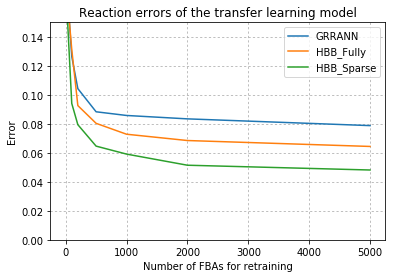

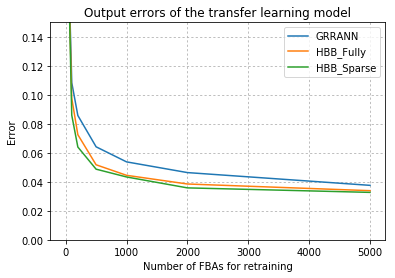

In [20]:
#Plotting the results of the errors depending on the number of instances for the training
nInst = [0, 100, 200, 500, 1000, 2000, 5000]
tit = ['Reaction','Output']
for i in range(2):
    plt.plot(nInst, grrannMAEs[i], label='GRRANN')
    plt.plot(nInst, hbbFMAEs[i], label='HBB_Fully')
    plt.plot(nInst, hbbSMAEs[i], label='HBB_Sparse')
    
    plt.legend(loc='upper right')
    plt.xlabel('Number of FBAs for retraining')
    plt.ylabel('Error')
    plt.ylim(0,0.15)
    plt.title('{} errors of the transfer learning model'.format(tit[i]))
    plt.grid(linestyle='dotted')
    plt.savefig('images/multiTransferSalmonella_Ecoli_{}.jpg'.format(tit[i]))
    plt.show()

In [24]:
predictions = model_transferS.predict(netInpsS)

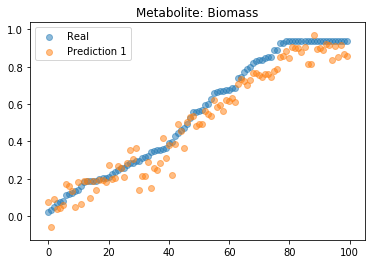

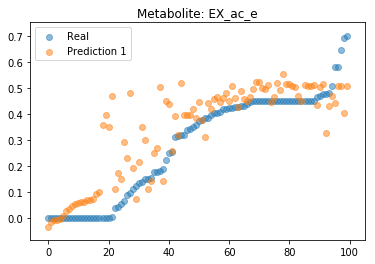

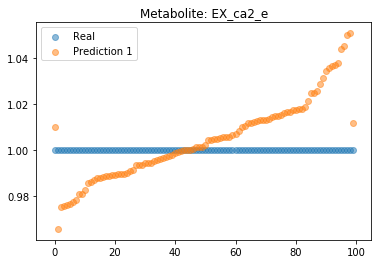

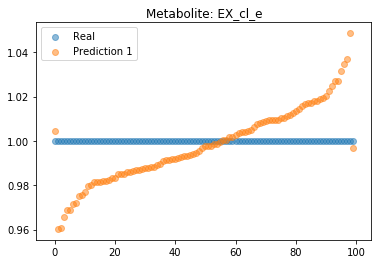

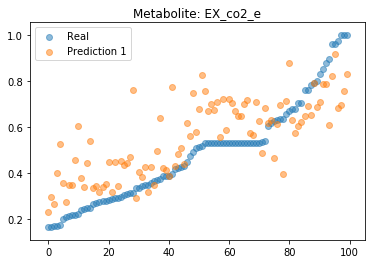

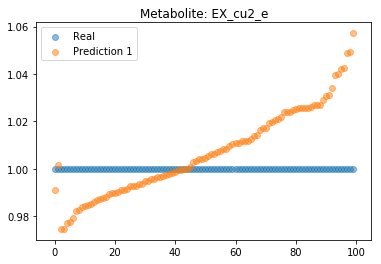

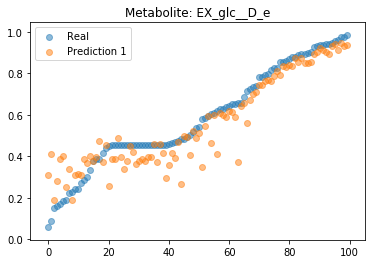

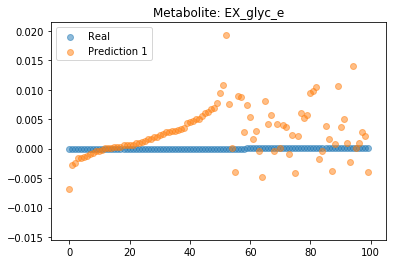

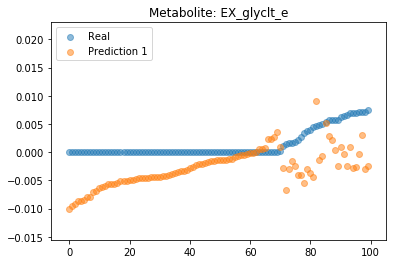

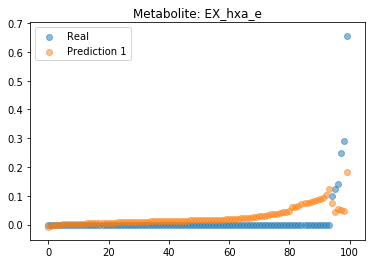

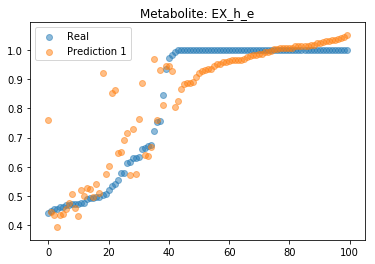

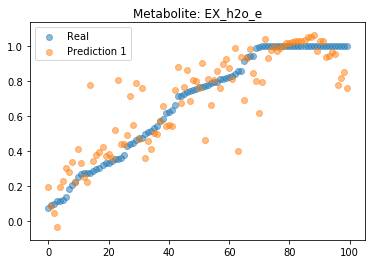

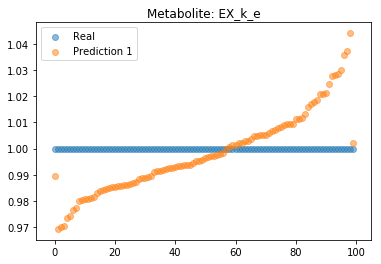

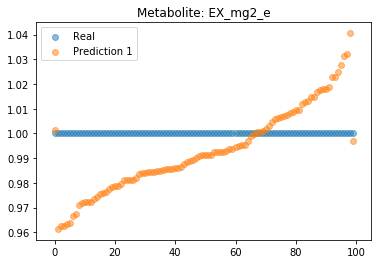

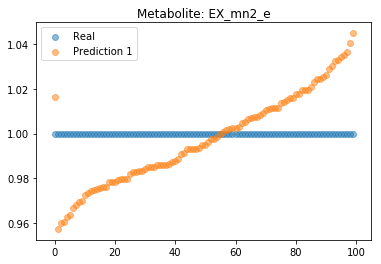

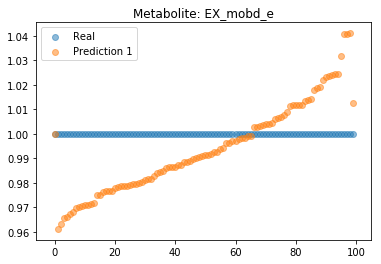

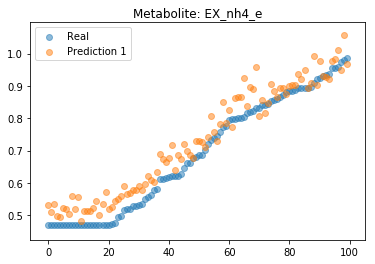

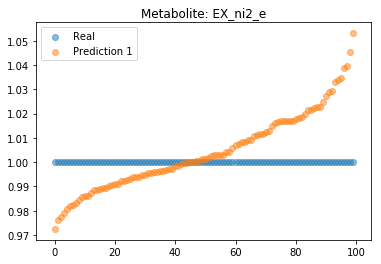

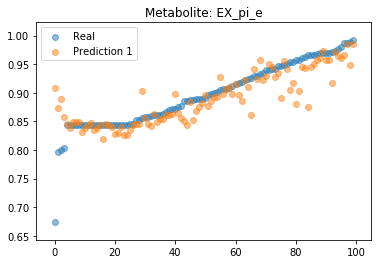

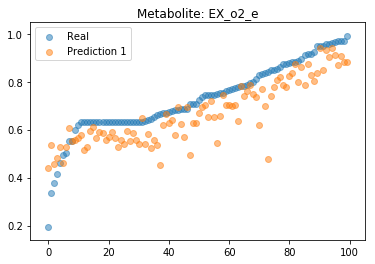

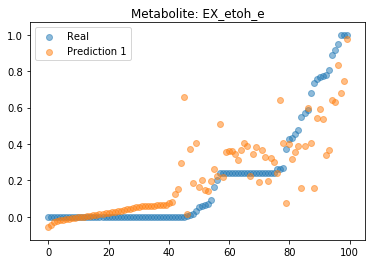

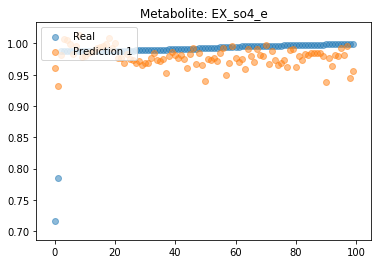

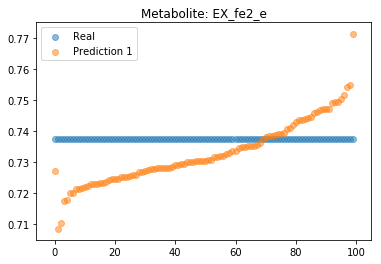

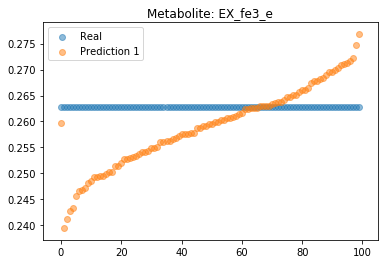

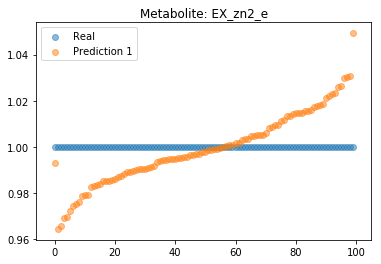

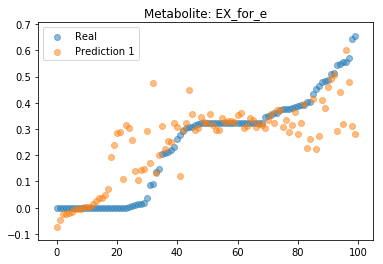

In [25]:
#Visualize the predictions vs the real values of some individuals for each output
n=200
for idx in range(predictions[1].shape[1]):
    plot_prediction_comparison([predictions[1][:n,idx]], netOutsS[1][:n,idx], glayersIds[1][idx])

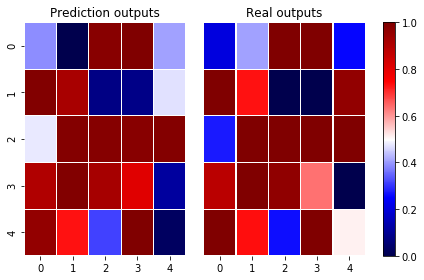

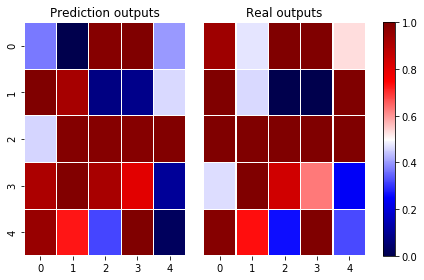

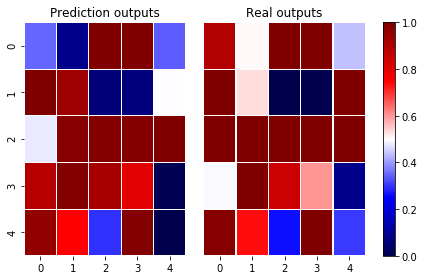

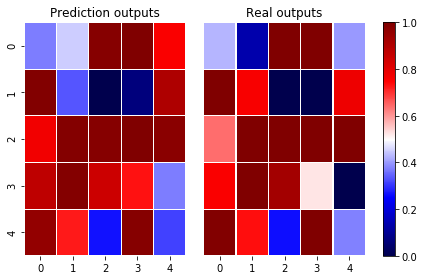

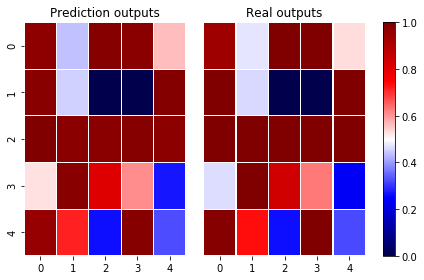

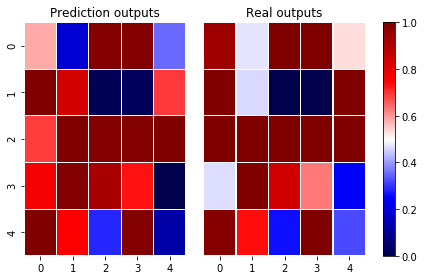

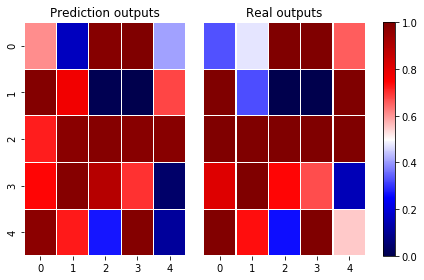

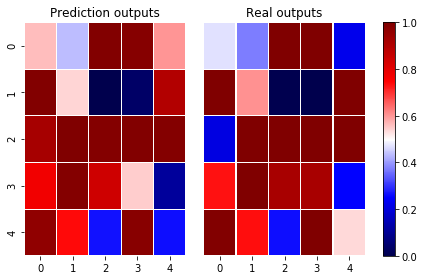

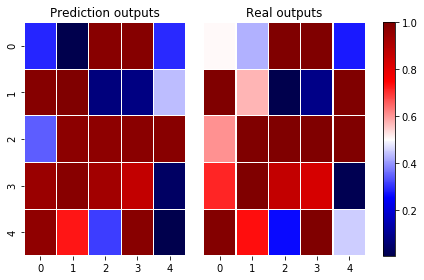

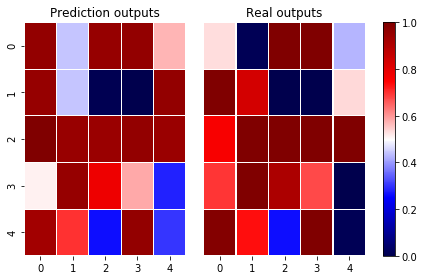

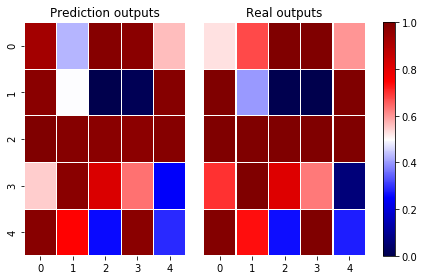

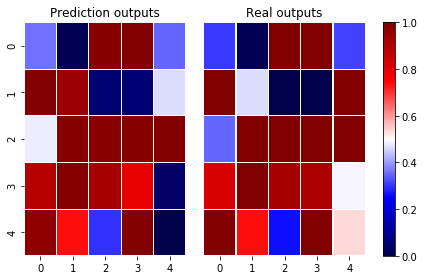

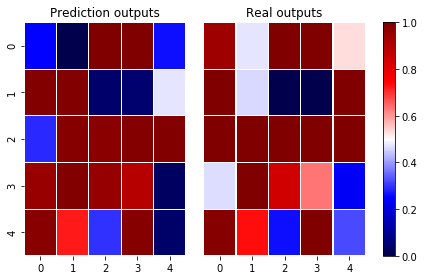

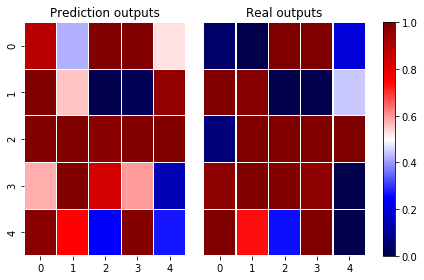

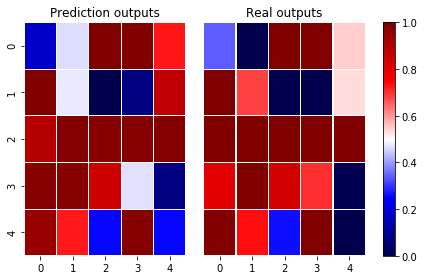

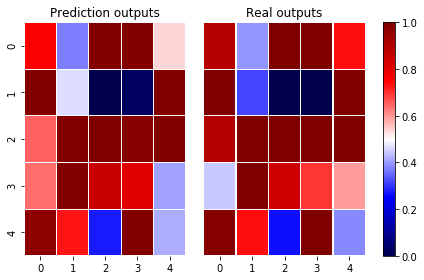

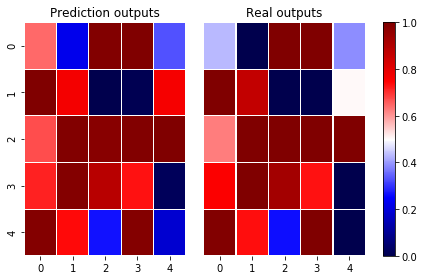

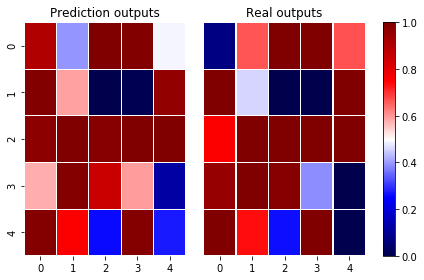

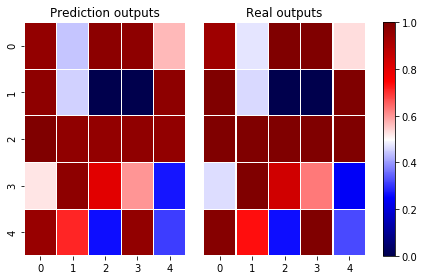

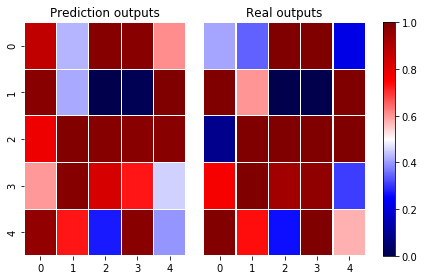

In [32]:
#Checking the real and predicted heatmaps of the outputs of several instances
for i in range(20):
    plotHeatmap(predictions[1], yTestS[-1], heatIdx=i, fillValue=0.5)#, save='outputsHeatmap.png')

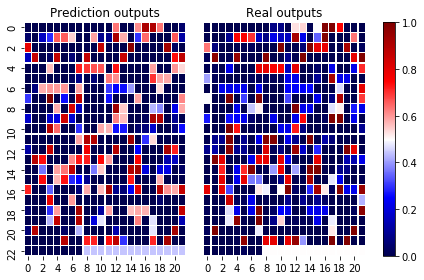

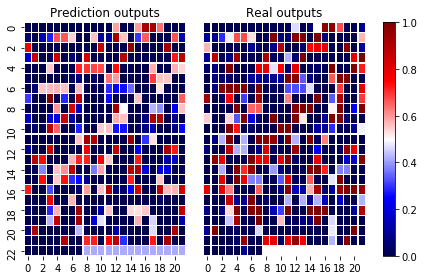

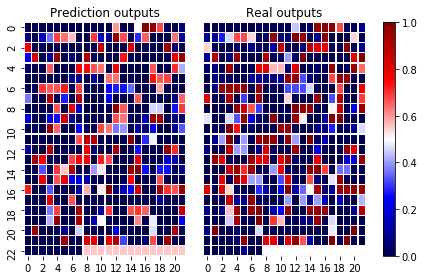

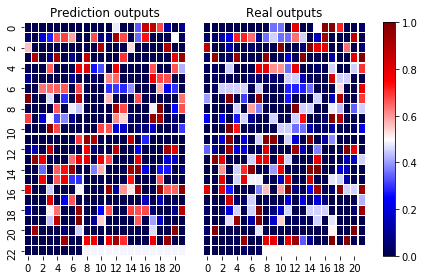

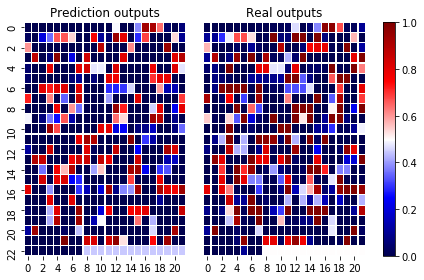

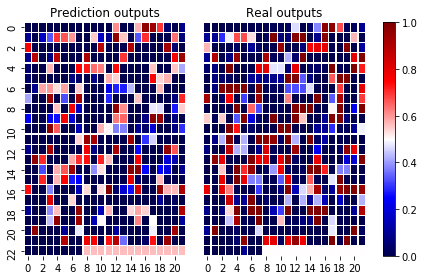

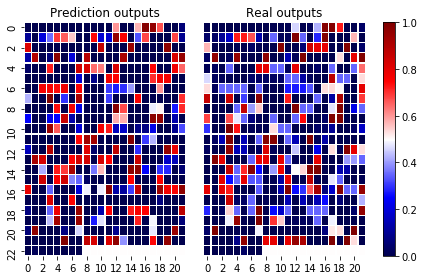

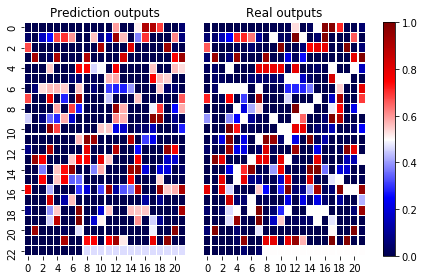

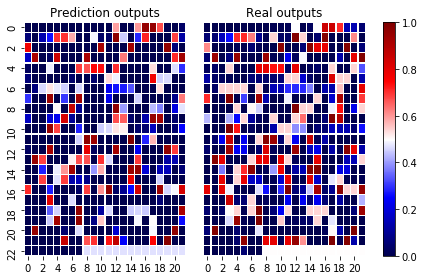

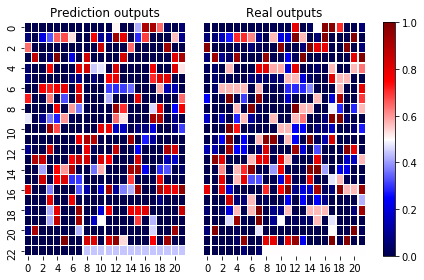

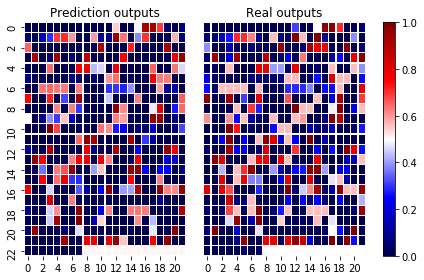

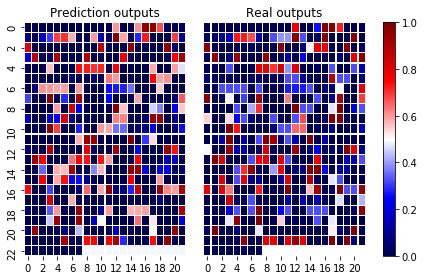

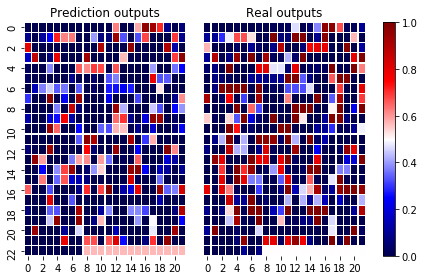

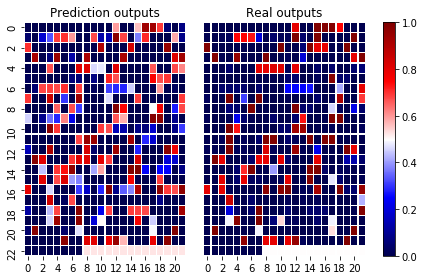

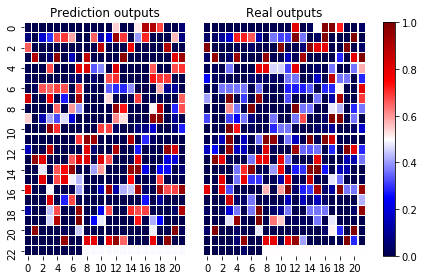

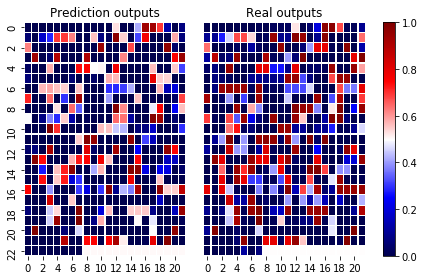

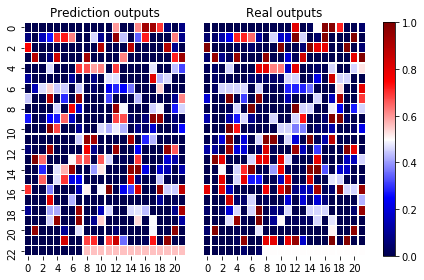

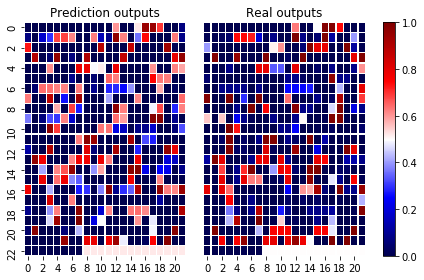

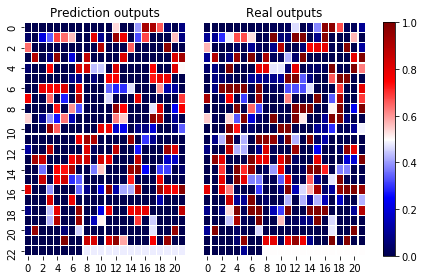

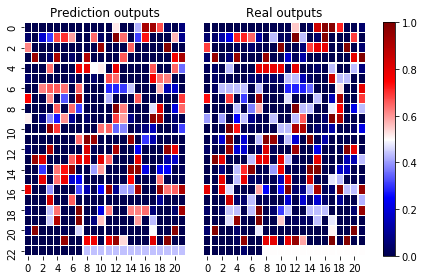

In [33]:
#Checking the real and predicted heatmaps of the inner reactions of several instances
for i in range(20):
    plotHeatmap(predictions[0], yTestS[0], heatIdx=i, fillValue=0.5)#, save='reactionsHeatmap.png')

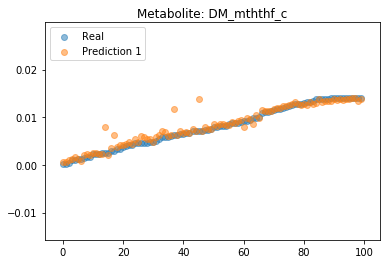

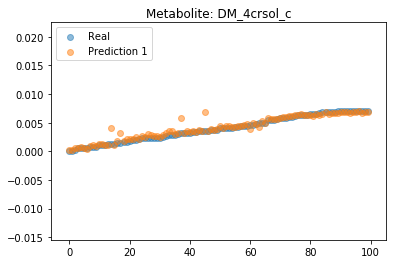

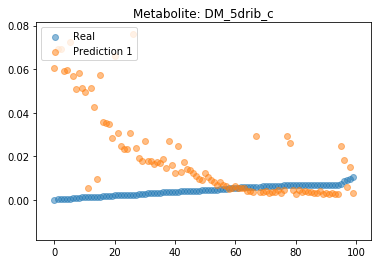

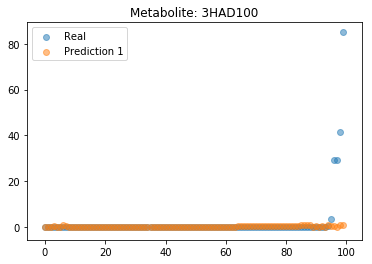

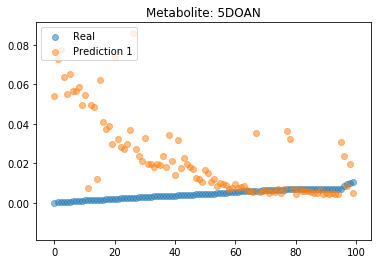

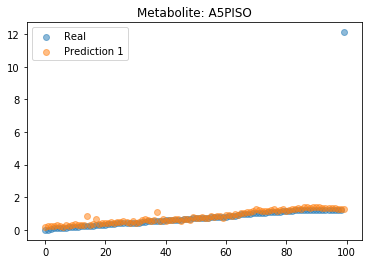

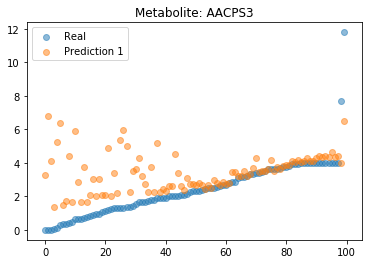

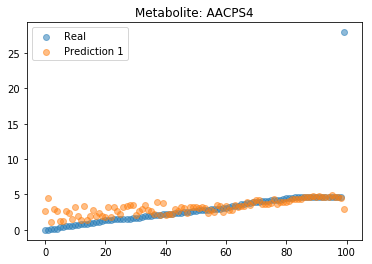

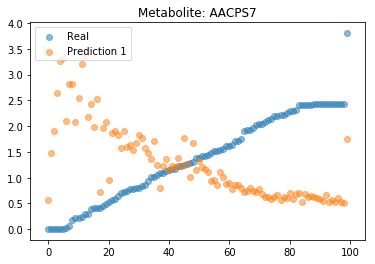

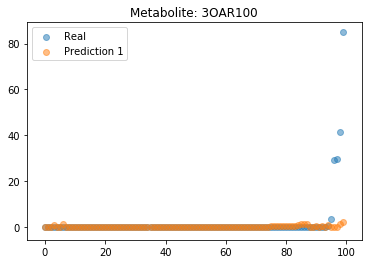

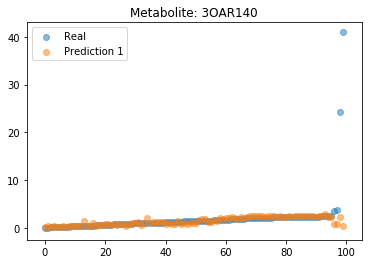

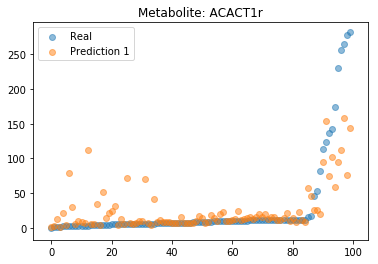

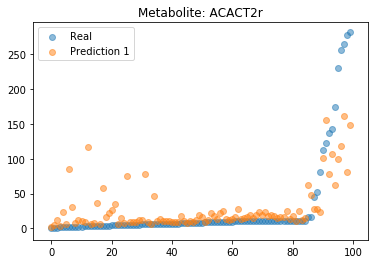

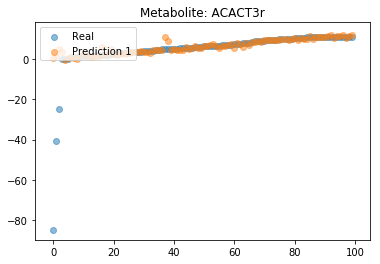

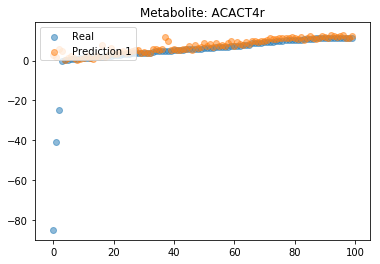

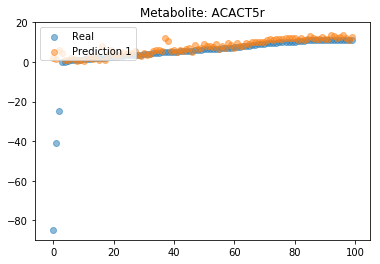

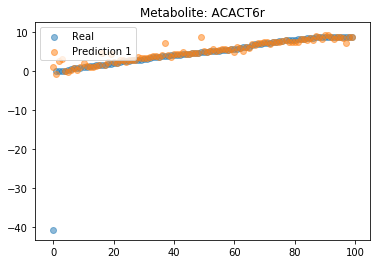

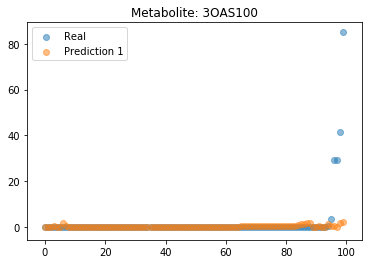

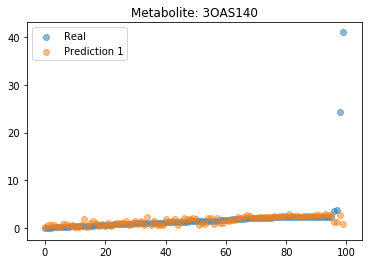

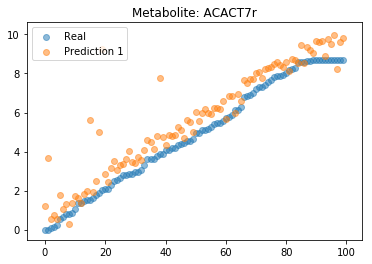

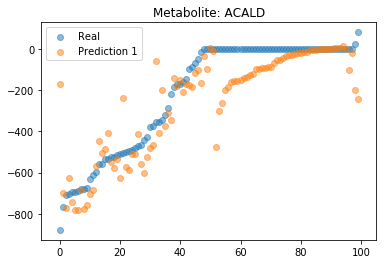

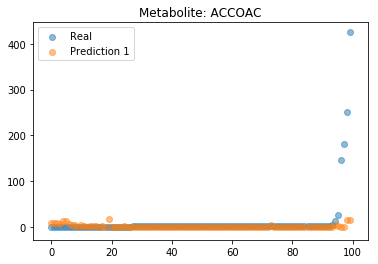

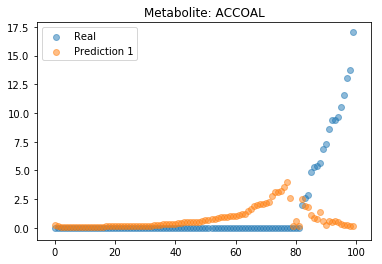

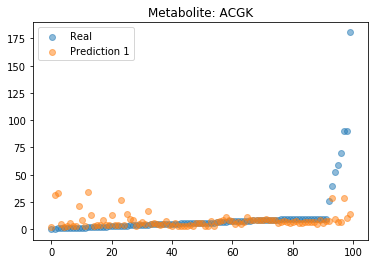

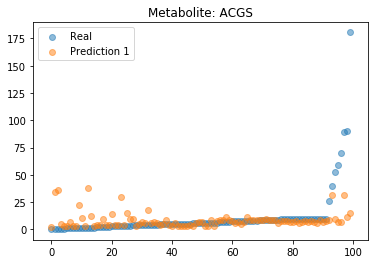

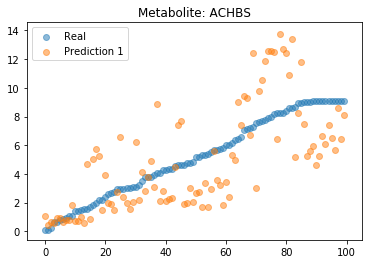

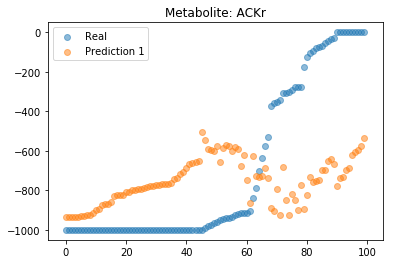

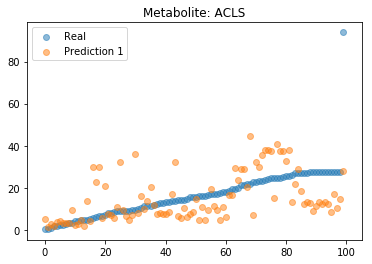

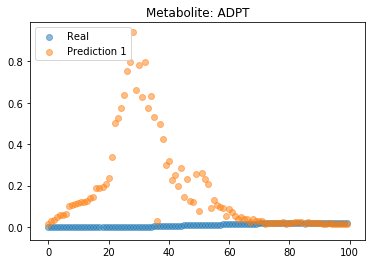

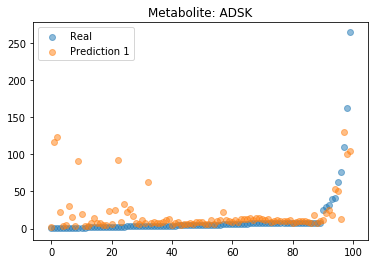

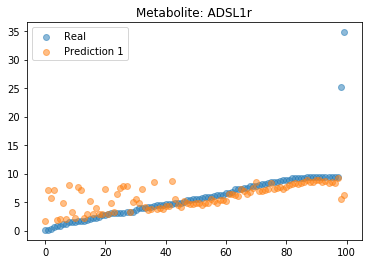

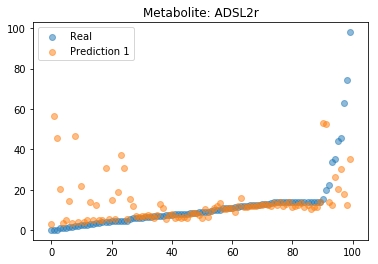

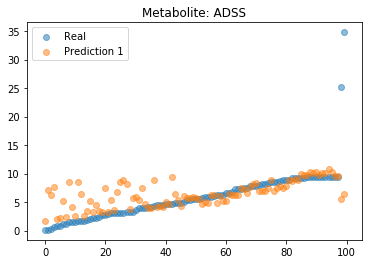

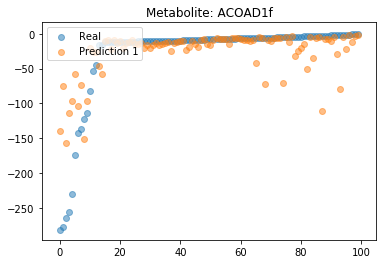

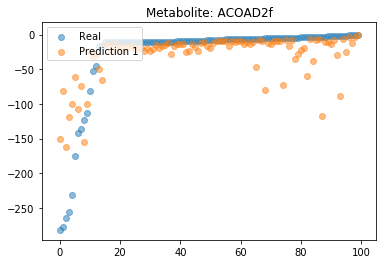

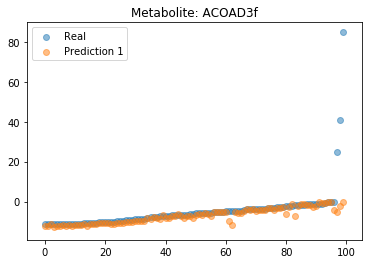

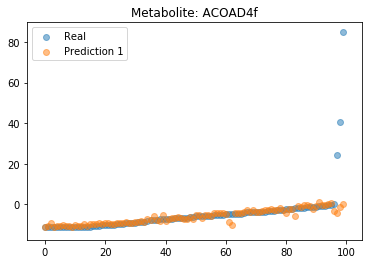

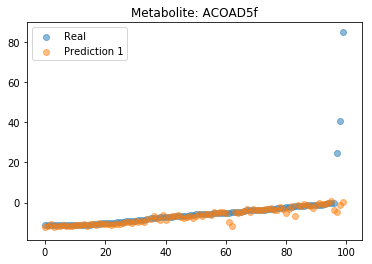

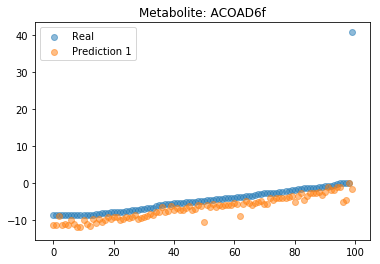

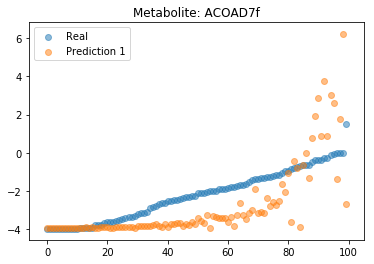

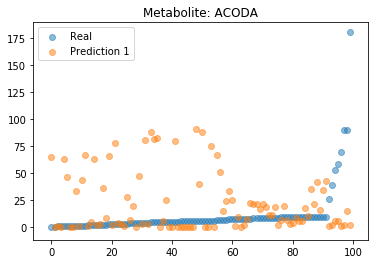

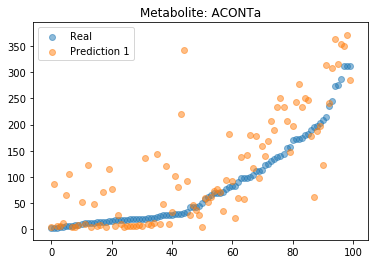

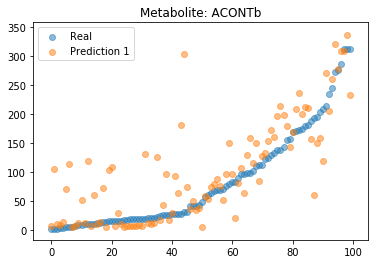

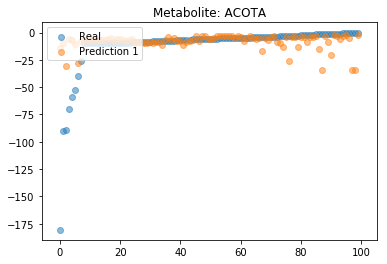

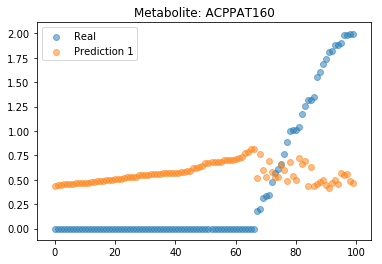

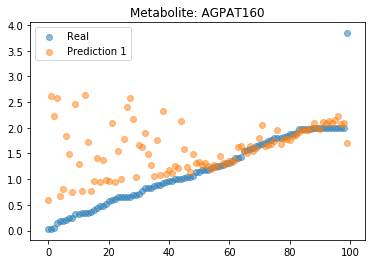

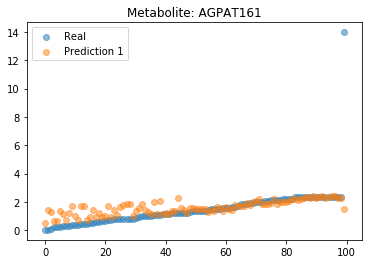

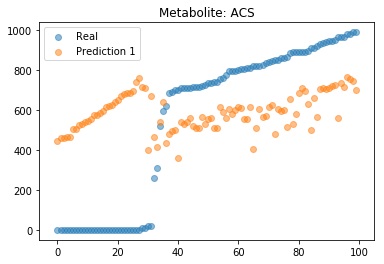

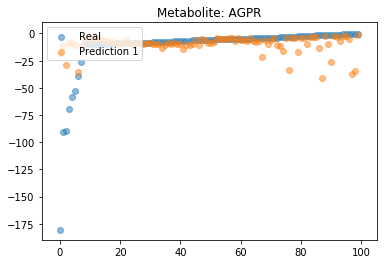

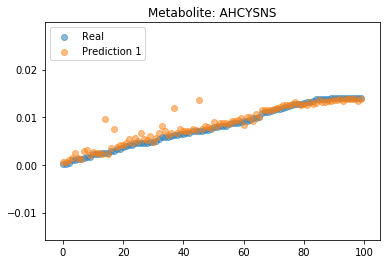

In [27]:
#Visualize the predictions vs the real values of some individuals for each output
n=100
for idx in range(50):#reactPreds.shape[1]):
    plot_prediction_comparison([reactPreds[:n,idx]], ryTest[-2][:n,idx], glayersIds[-2][idx])

In [38]:
bioIdx=biomassIndex(glayersIds[-1])
print('Biomass error: ',mean_absolute_error(predictions[0][:,bioIdx], netOutsS[-1][:,bioIdx]))

Biomass error:  0.595898456266002


In [57]:
print(bioIdx)
print(glayersIds[-1])

0
['BIOMASS_Ec_iJO1366_core_53p95M' 'EX_cu2_e' 'EX_ac_e' 'EX_etoh_e'
 'EX_fe2_e' 'EX_fe3_e' 'EX_glyclt_e' 'EX_for_e' 'EX_ca2_e' 'EX_cl_e'
 'EX_co2_e' 'EX_glc__D_e' 'EX_h_e' 'EX_h2o_e' 'EX_pi_e' 'EX_so4_e'
 'EX_hxa_e' 'EX_zn2_e' 'EX_k_e' 'EX_mg2_e' 'EX_mn2_e' 'EX_mobd_e'
 'EX_nh4_e' 'EX_ni2_e' 'EX_o2_e']
